In [5]:
import psycopg2
import pandas as pd
from pandas.plotting import register_matplotlib_converters 

# Connect to covid19db.org
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)
cur = conn.cursor()
cur.execute("""SELECT * FROM government_response WHERE date<now() ORDER BY date""")

govtrack_data = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

In [6]:
govtrack_data.dropna(subset=['confirmed'], inplace=True)
govtrack_data.head()

,source,date,country,countrycode,adm_area_1,adm_area_2,adm_area_3,confirmed,dead,stringency,stringency_actual,actions
0,GOVTRACK,2020-01-01,Madagascar,MDG,None,None,None,0,0,0,0,"{'policyActions': [{'notes': None, 'isgeneral'..."
1,GOVTRACK,2020-01-01,Brazil,BRA,None,None,None,0,0,0,0,"{'policyActions': [{'notes': '', 'isgeneral': ..."
2,GOVTRACK,2020-01-01,Austria,AUT,None,None,None,0,0,0,0,"{'policyActions': [{'notes': '', 'isgeneral': ..."
3,GOVTRACK,2020-01-01,Australia,AUS,None,None,None,0,0,7,7,"{'policyActions': [{'notes': '', 'isgeneral': ..."
4,GOVTRACK,2020-01-01,Netherlands,NLD,None,None,None,0,0,0,0,"{'policyActions': [{'notes': None, 'isgeneral'..."


In [7]:
# Extract policy_type_code==S1 (School closing) as a separate column
def check_S1_policy_only(d):
    actions = d.get('policyActions', {})
    for action in actions:
        if action.get('policy_type_code') == 'S1':
            policyvalue = action.get('policyvalue', 0)
            if isinstance(policyvalue, int) and policyvalue > 0:
                # print(action.get('policyvalue'))
                return action.get('policyvalue')
    return 0

In [15]:
policy_actions_pl = {}

# Extract actions and store first occurence of policy_type_code in dict
def check_policy_actions(row, policy_actions):
    date, confirmed, actions = row  
    
    policy = actions.get('policyActions', {})
    for action in policy:
        policy_code = action.get('policy_type_code')
        policyvalue = action.get('policyvalue', 0)
        if policy_code in ['S99', 'S12']: # Skip 'Testing Framework' and 'No data' actions
            continue
        if isinstance(policyvalue, int) and policyvalue > 0:                
            if policy_code not in policy_actions:
                policy_actions[policy_code] = {
                        'first_date': date,
                        'confirmed': confirmed,
                        'policy_type_display': f"{policy_code} - {date}, {action.get('policy_type_display')}",
                        'policy_type_code': policy_code,
                        'color_index': int(policy_code.replace('S',''))
                }
                # print(date, confirmed, action.get('policyvalue'))
        
    return policy_actions


In [16]:
# Example of finfing first date of school_closing policy in Poland
govtrack_PL = govtrack_data[govtrack_data['countrycode'] == 'POL'].reset_index()

_ = govtrack_PL[['date','confirmed','actions']].apply(lambda row: check_policy_actions(row, policy_actions_pl), axis=1)


govtrack_PL['school_closing'] = govtrack_PL.actions.map(lambda d : check_S1_policy_only(d))

first_index = govtrack_PL[govtrack_PL.school_closing>0].first_valid_index()
record = govtrack_PL.iloc[first_index]
date = record.date.strftime('%Y-%m-%d')
print(f"First indes with scool closed: {first_index}, date: {date}")
school_closing_event=(record.date, record.confirmed)
record.actions.get('policyActions')[0]

First indes with scool closed: 71, date: 2020-03-12


{'notes': 'Poland announces closure of all schools and pre-schools from March 12-25 https://www.gov.pl/web/koronawirus/zawieszenie-zajec ',
 'isgeneral': True,
 'policyvalue': 2,
 'policy_type_code': 'S1',
 'policy_type_display': 'School closing'}

### Plotting govermental decisions data

Plotting function:

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import matplotlib.cm as cm
import matplotlib.dates as mdates

def plot(govtrack_data, policy_actions):
    fig = plt.figure()
    ax = plt.axes()

    ax.plot(govtrack_data['confirmed'],  linestyle='-', label='confirmed cases')
    colors = cm.rainbow(np.linspace(0, 1, 14) )
    
    sorted_lebels = sorted(policy_actions.items(), key=lambda key: int(key[0].replace('S','')))
    for key, value in sorted_lebels:   
        date = value.get('first_date')
        y_value = value.get('confirmed')
        label = value.get('policy_type_display')
        ax.scatter(date, y_value, 
                   color=colors[value.get('color_index')], 
                   marker='s', 
                   alpha=0.7, 
                   s=100, 
                   label=label, 
                   cmap=cm.jet)

    ax.set_ylabel('Daily confirmed cases')
    ax.set_title('Time')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));


    plt.xticks(rotation=45)
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), labelspacing=1)
    
def plot_country(country_code):
    govtrack = govtrack_data[govtrack_data['countrycode'] == country_code].reset_index()
    policy_actions = {}
    _ = govtrack[['date','confirmed','actions']].apply(lambda row: check_policy_actions(row, policy_actions), axis=1)
    plot(govtrack.set_index('date'), policy_actions)
    

### Data for Poland

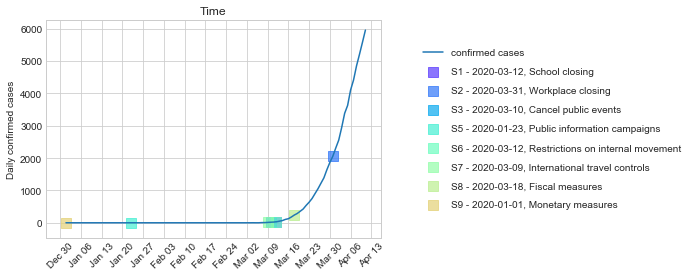

In [18]:
plot_country('POL')

### Data for UK


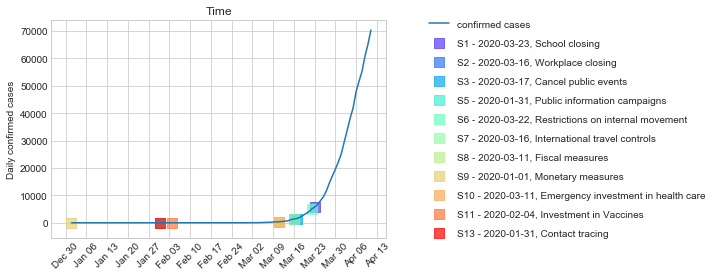

In [19]:
plot_country('GBR')

### Data for Italy

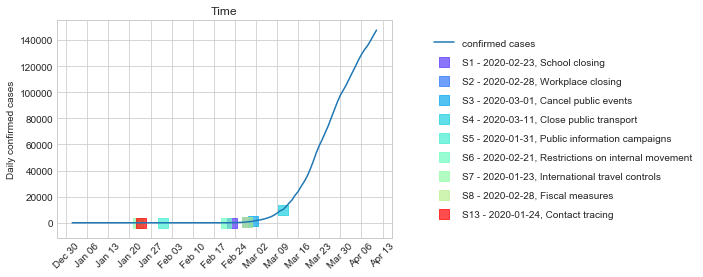

In [20]:
plot_country('ITA')

### Data for USA

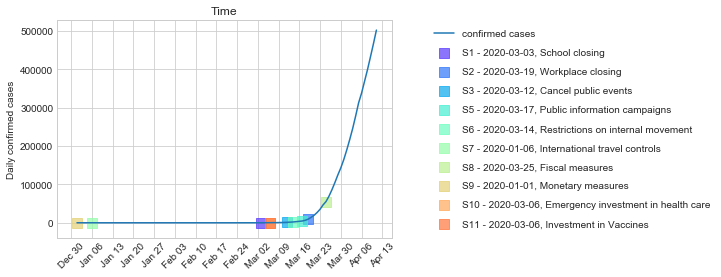

In [21]:
plot_country('USA')

### Data for Spain

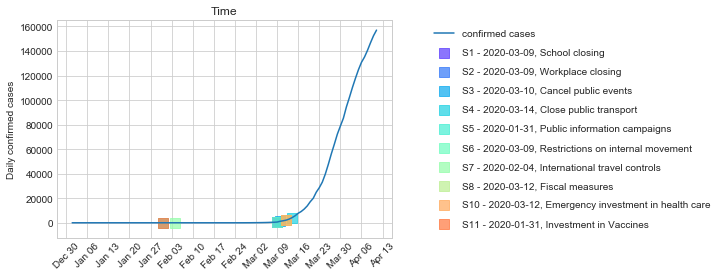

In [22]:
plot_country('ESP')